<a href="https://colab.research.google.com/github/JeffreyAsuncion/DS-Unit-2-Linear-Models/blob/master/DSPT6_U2S1M3_JeffreyAsuncion_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [x] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [x] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

1. Use a subset of the data
=========
 where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] < 2000000)]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


626887.983233154


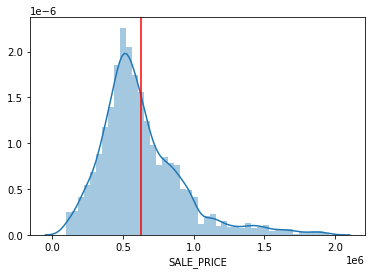

In [0]:
# Let's have a look at our target
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
print(df['SALE_PRICE'].mean())
sns.distplot(df['SALE_PRICE']);
plt.axvline(df['SALE_PRICE'].mean(), color='r')
plt.show();

In [0]:
df.sample(3)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
16606,2,OTHER,01 ONE FAMILY DWELLINGS,1,4473,18,NaN,A1,2428 MORGAN AVENUE,NaN,10469.0,1.0,0.0,1.0,"5,000",1200.0,1920.0,1,A1,690000,03/25/2019
2104,5,OTHER,01 ONE FAMILY DWELLINGS,1,430,10,NaN,A1,301 CLINTON B FISK AVE,NaN,10314.0,1.0,0.0,1.0,"3,000",1088.0,1925.0,1,A1,630000,01/11/2019
10629,4,OTHER,01 ONE FAMILY DWELLINGS,1,6901,13,NaN,A5,173-03 65TH AVENUE,NaN,11365.0,1.0,0.0,1.0,"2,600",1044.0,1950.0,1,A5,785000,02/22/2019


In [0]:
# drop BUILDING_CLASS_CATEGORY and EASE-MENT
df = df.drop('BUILDING_CLASS_CATEGORY', axis=1) # same for all rows
df = df.drop('EASE-MENT', axis=1) # this is mostly all NaNs
df = df.drop('APARTMENT_NUMBER', axis=1) # this is mostly all NaNs

df = df.drop('TAX_CLASS_AT_TIME_OF_SALE', axis=1) # this is constant number

 2. Do train/test split.
 =========
 Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
# Split the data into two sets
train = df[(df['SALE_DATE'] >= '01/01/2019') & (df['SALE_DATE'] < '04/01/2019')]
test = df[df['SALE_DATE'] >= '04/01/2019']
train.shape, test.shape

((2515, 17), (646, 17))

In [0]:
# to stop the Pandas warning from popping up
train = train.copy()
test = test.copy()

In [0]:
train.sample(3)

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
11477,3,OTHER,1,8547,29,A9,2037 EAST 55TH STREET,11234.0,1.0,0.0,1.0,"2,000",1248.0,1920.0,A9,600000,02/27/2019
3535,4,OTHER,1,11670,5,A0,126-10 115TH AVENUE,11420.0,1.0,0.0,1.0,"3,300",1208.0,1945.0,A0,362900,01/18/2019
13336,5,OTHER,1,6993,42,A2,49 IDAHO AVENUE,10309.0,1.0,0.0,1.0,"18,009",1084.0,1950.0,A2,800000,03/07/2019


In [0]:
train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2515.0,6754.701392,3976.314767,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2515.0,75.681511,157.294857,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2515.0,10993.703777,494.206275,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2515.0,0.987674,0.110358,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2515.0,0.016302,0.129763,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2515.0,1.003976,0.171521,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2515.0,1473.006759,599.069731,0.0,1144.0,1364.0,1681.5,7875.0
YEAR_BUILT,2515.0,1944.757455,27.047985,1890.0,1925.0,1940.0,1960.0,2018.0
SALE_PRICE,2515.0,619914.660835,292621.089510,100000.0,440000.0,560000.0,750000.0,1955000.0


3. Do one-hot encoding of categorical features.
=====


In [0]:
train.describe(exclude='number').T

,count,unique,top,freq
BOROUGH,2515,5,4,1209
NEIGHBORHOOD,2515,6,OTHER,2388
TAX_CLASS_AT_PRESENT,2515,2,1,2484
BUILDING_CLASS_AT_PRESENT,2515,13,A1,921
ADDRESS,2515,2505,130-52 LEFFERTS BOULEVARD,2
LAND_SQUARE_FEET,2515,888,"4,000",235
BUILDING_CLASS_AT_TIME_OF_SALE,2515,11,A1,921
SALE_DATE,2515,68,01/31/2019,78


In [0]:
#### Running this more than once will cause errors
train['LAND_SQUARE_FEET'] = (train['LAND_SQUARE_FEET'].str.replace(',','').astype(int))
test['LAND_SQUARE_FEET'] = (test['LAND_SQUARE_FEET'].str.replace(',','').astype(int))
#### now 'LAND_SQUARE_FEET' is not a categorical variable

In [0]:
train.describe(exclude='number').T

,count,unique,top,freq
BOROUGH,2515,5,4,1209
NEIGHBORHOOD,2515,6,OTHER,2388
TAX_CLASS_AT_PRESENT,2515,2,1,2484
BUILDING_CLASS_AT_PRESENT,2515,13,A1,921
ADDRESS,2515,2505,130-52 LEFFERTS BOULEVARD,2
BUILDING_CLASS_AT_TIME_OF_SALE,2515,11,A1,921
SALE_DATE,2515,68,01/31/2019,78


In [0]:
# the following are values to be excluded
#. 'BUILDING_CLASS_CATEGORY' - is only one value '01 ONE FAMILY DWELLINGS' due to intial sort	
#. 'ADDRESS'
#. 'APARTMENT_NUMBER'
#. 'SALE_DATE'
train[['BUILDING_CLASS_AT_PRESENT','BUILDING_CLASS_AT_TIME_OF_SALE']] # this value doesn't change

,BUILDING_CLASS_AT_PRESENT,BUILDING_CLASS_AT_TIME_OF_SALE
44,A9,A9
61,A1,A1
78,A1,A1
108,A1,A1
111,A5,A5
...,...,...
18129,A2,A2
18130,A5,A5
18132,A1,A1
18134,A2,A2


The other non-numeric columns have high cardinality. So let's exclude them from our features for now.

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS','BUILDING_CLASS_AT_PRESENT',
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'] ##### add the columns to exclude
features = train.columns.drop([target] + high_cardinality)
features # these are the features we will keep 

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT'],
      dtype='object')

In [0]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, X_test.shape

((2515, 12), (646, 12))

In [0]:
X_train.head(5).T

,44,61,78,108,111
BOROUGH,3,4,2,3,3
NEIGHBORHOOD,OTHER,OTHER,OTHER,OTHER,OTHER
TAX_CLASS_AT_PRESENT,1,1,1,1,1
BLOCK,5495,7918,4210,5212,7930
LOT,801,72,19,69,121
ZIP_CODE,11230,11427,10461,11226,11203
RESIDENTIAL_UNITS,1,1,1,1,1
COMMERCIAL_UNITS,0,0,0,0,0
TOTAL_UNITS,1,1,1,1,1
LAND_SQUARE_FEET,6800,4000,3500,4000,1710


Use OneHotEncoder to encode any non-numeric features
=======
- use the `fit_transform` method on the **train** set
- use the `transform` method on the **validation/test** sets

In [0]:
# Estimator = anything with a .fit() method: includes models
# Predictor = anything with a .predict() method: includes models
# Transformer = anything with a .transform() method: includes transformers

import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [0]:
X_train.shape, X_test.shape
# notice more columns. yay!

((2515, 22), (646, 22))

4. Do feature selection with `SelectKBest`.
==========


1 features
Test Mean Absolute Error: $184,082 

2 features
Test Mean Absolute Error: $180,034 

3 features
Test Mean Absolute Error: $171,462 

4 features
Test Mean Absolute Error: $170,788 

5 features
Test Mean Absolute Error: $168,858 

6 features
Test Mean Absolute Error: $168,953 

7 features
Test Mean Absolute Error: $168,652 

8 features
Test Mean Absolute Error: $165,760 

9 features
Test Mean Absolute Error: $165,262 

10 features
Test Mean Absolute Error: $166,022 

11 features
Test Mean Absolute Error: $156,387 

12 features
Test Mean Absolute Error: $158,166 

13 features
Test Mean Absolute Error: $156,000 

14 features
Test Mean Absolute Error: $156,029 

15 features
Test Mean Absolute Error: $155,616 

16 features
Test Mean Absolute Error: $155,781 

17 features
Test Mean Absolute Error: $155,675 

18 features
Test Mean Absolute Error: $156,602 

19 features
Test Mean Absolute Error: $156,605 

20 features
Test Mean Absolute Error: $156,709 

21 features
Test Mean Absolut

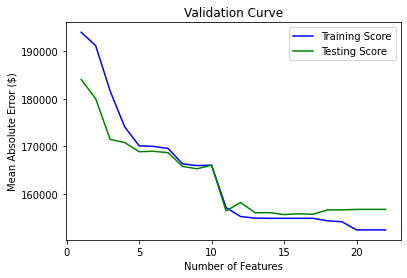

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest

training = []
testing = []
ks = range(1, len(X_train.columns)+1)
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    testing.append(mae)
    print(f"Test Mean Absolute Error: ${mae:,.0f} \n")

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color= 'g')
plt.ylabel("Mean Absolute Error ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
#plt. axvline(4, color='gray')
plt.show();


In [0]:
# 15 features
# Test Mean Absolute Error: $155,616
k = 15
selector = SelectKBest(score_func=f_regression,k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mae1 = mean_absolute_error(y_test, y_pred)
  
print(f"Linear Regression - Test Mean Absolute Error: ${mae1:,.0f} \n")

Linear Regression - Test Mean Absolute Error: $155,616 



In [0]:
# TODO: Which features were selected?

selected_mask = selector.get_support() # this method lets us know which columns were selected
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures excluded:')
for name in unselected_names:
    print(name)   

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_1D
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET

Features excluded:
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
LOT
RESIDENTIAL_UNITS
YEAR_BUILT



Fit a ridge regression model w. multi features. & Get mean absolute error for the test set.
==============

 Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)

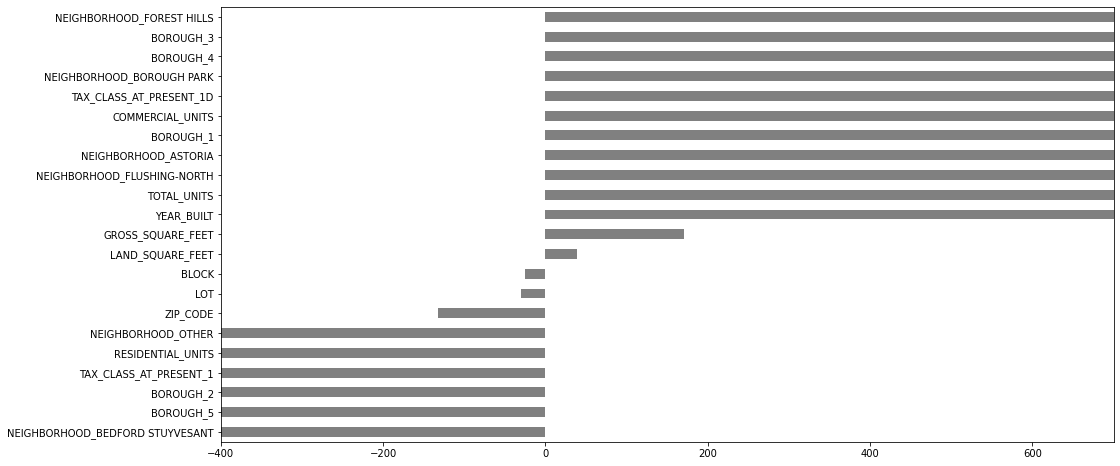

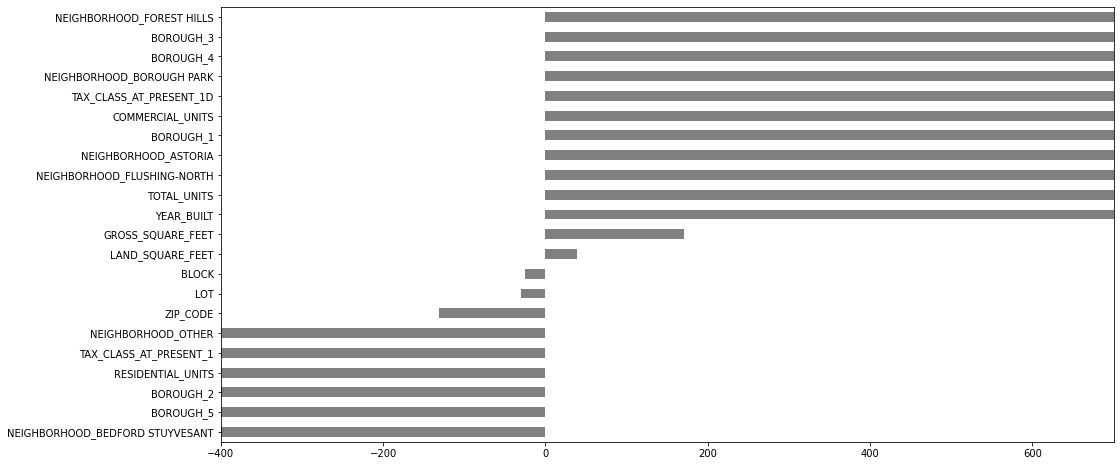

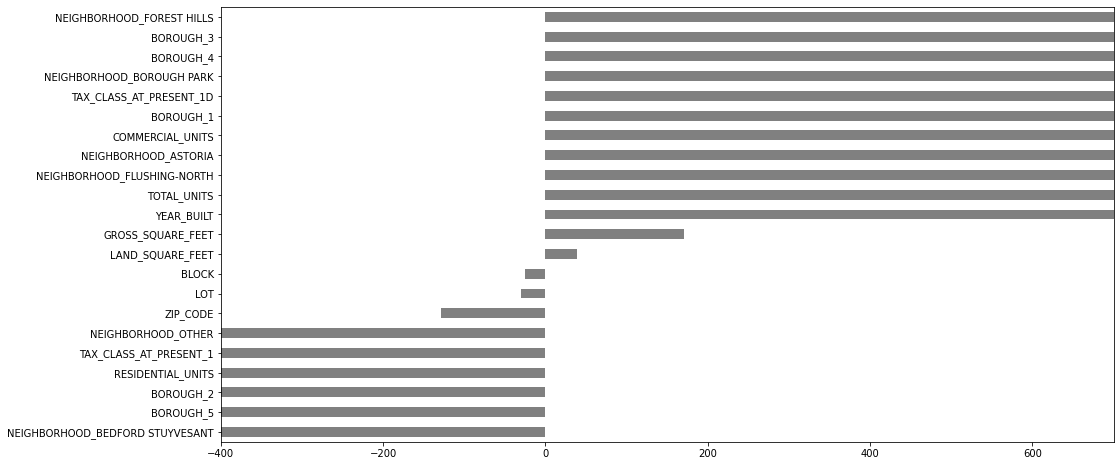

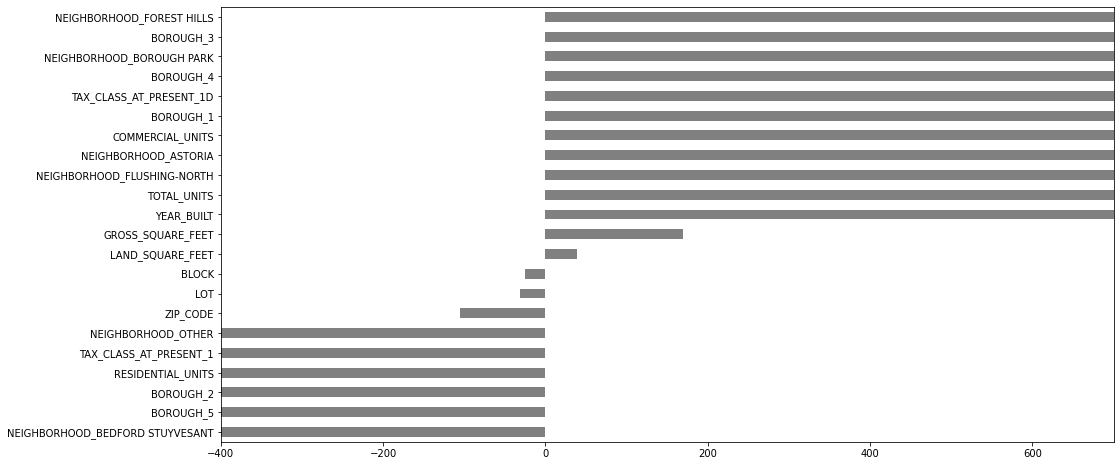

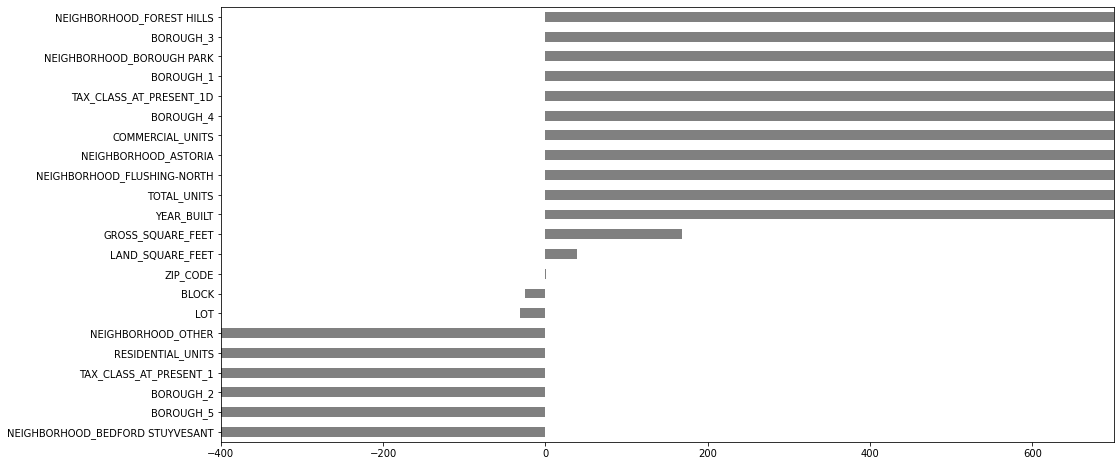

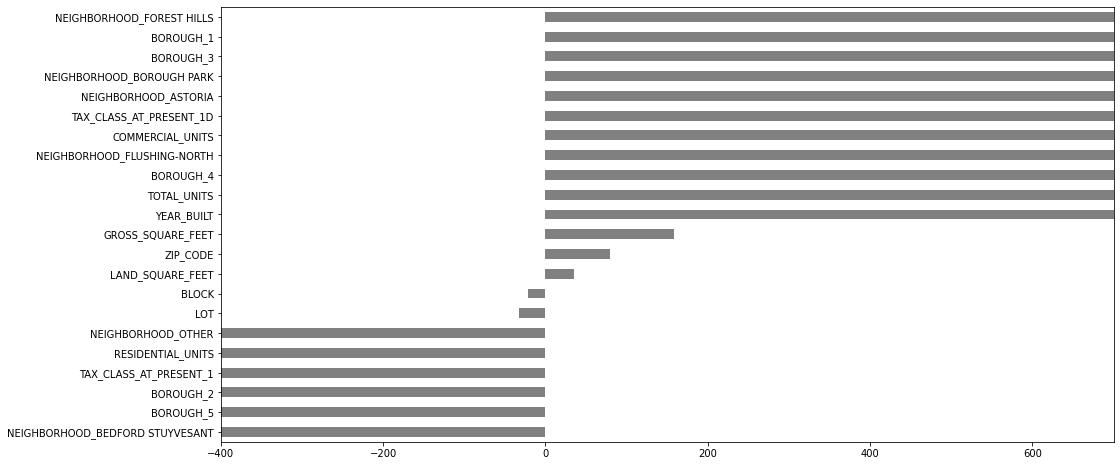

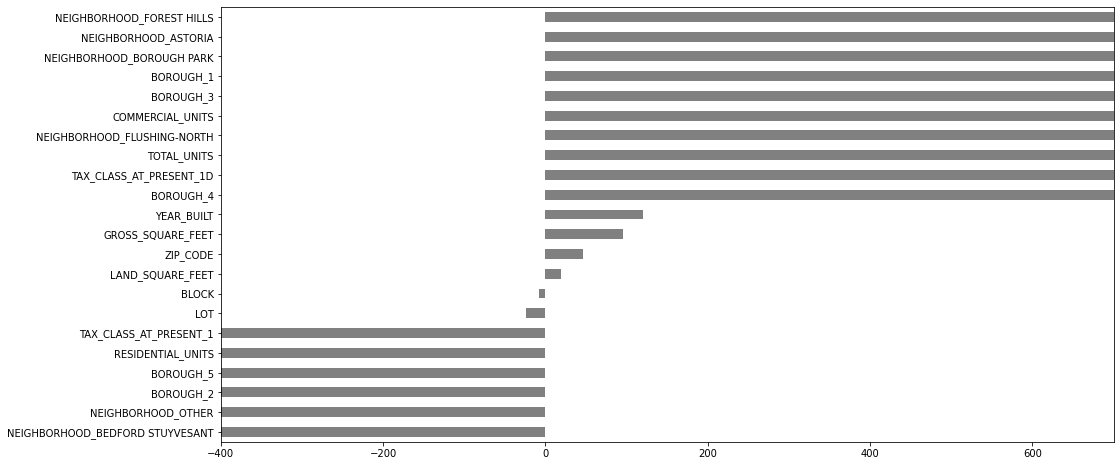

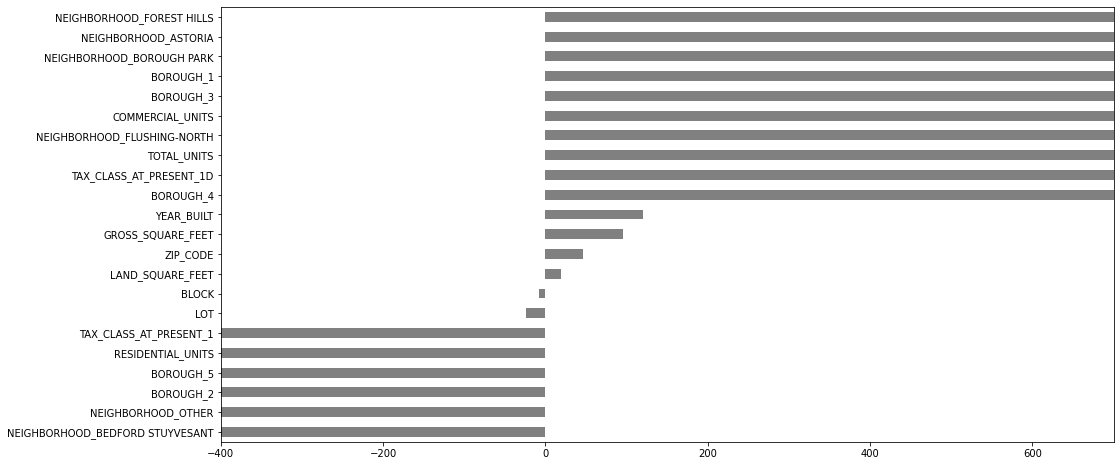

In [0]:
from IPython.display import display, HTML
from sklearn.linear_model import Ridge

for alpha in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 1]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

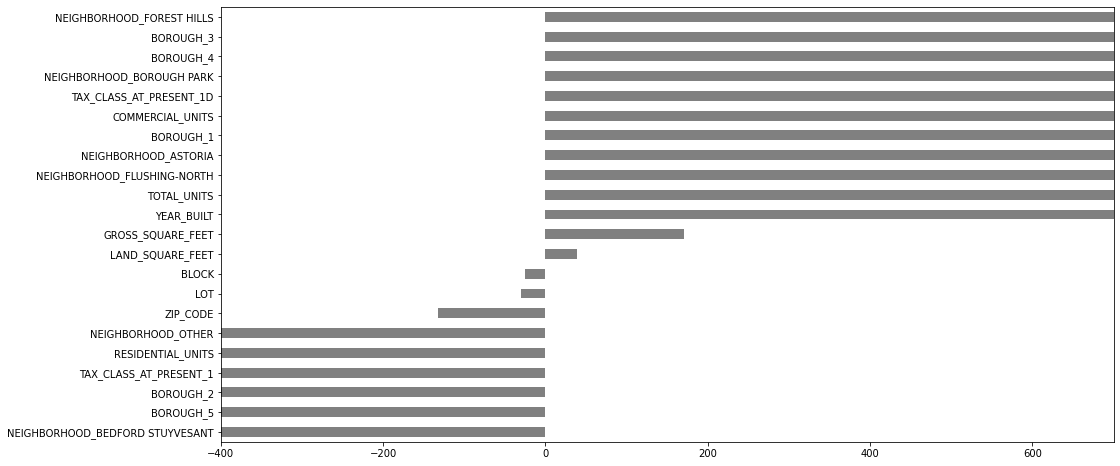

In [0]:
# Ridge Regression, with alpha=1e-06
# Test Mean Absolute Error: $156,695

alpha = 0.000001
# Fit Ridge Regression model
display(HTML(f'Ridge Regression, with alpha={alpha}'))
model = Ridge(alpha=alpha, normalize=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Get Test MAE
mae2 = mean_absolute_error(y_test, y_pred)
display(HTML(f'Ridge Regression - Test Mean Absolute Error: ${mae2:,.0f}'))
    
# Plot coefficients
coefficients = pd.Series(model.coef_, X_train.columns)
plt.figure(figsize=(16,8))
coefficients.sort_values().plot.barh(color='grey')
plt.xlim(-400,700)
plt.show()